In [1]:
# prepare libs

import os
# from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm, trange


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import PIL
print(PIL.__version__)
print ("all libs imported")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


9.5.0
all libs imported


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# get images
# !ls -la drive/MyDrive/Stepik_ML/pinocchio

# !unzip drive/MyDrive/Stepik_ML/pinocchio/journey-springfield.zip -d drive/MyDrive/Stepik_ML/pinocchio/images



In [2]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
print("ok")

ok


In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            self.classes = self.label_encoder.classes_


            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [3]:
# класс для efficient net с аугментацией
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            self.classes = self.label_encoder.classes_
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

        # Аугментации для тренировочных данных
        if self.mode == 'train':
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(RESCALE_SIZE),
                transforms.CenterCrop(RESCALE_SIZE),
                transforms.RandomRotation(30),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            # Более стандартные преобразования для валидации и тестирования
            self.transform = transforms.Compose([
                transforms.Resize(RESCALE_SIZE),
                transforms.CenterCrop(RESCALE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [ ]:
# класс для Inception
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который параллельно подгружает их из папок,
    производит масштабирование и превращение в тензоры PyTorch.
    """
    def __init__(self, files, mode):
        super().__init__()
        # Список файлов для загрузки
        self.files = sorted(files)
        # Режим работы
        self.mode = mode
        # Проверка корректности режима
        if self.mode not in ['train', 'val', 'test']:
            print(f"{self.mode} is not correct; correct modes: ['train', 'val', 'test']")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        # Определение трансформаций
        self.transformations = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(299),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(299),
                transforms.CenterCrop(299),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

        if self.mode != 'test':
            self.labels = [path.parent.name for path in map(Path, self.files)]
            self.label_encoder.fit(self.labels)
            self.classes = self.label_encoder.classes_
            # Сохранение label_encoder для последующего использования
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # Загрузка изображения
        x = self.load_sample(self.files[index])
        # Применение трансформаций
        x = self.transformations[self.mode](x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

print("ok")

In [4]:
#определим директории с тренировочными и тестовыми файлами
# PATH_TO_IMAGES = 'drive/MyDrive/Stepik_ML/pinocchio/images'
# TRAIN_DIR = Path(PATH_TO_IMAGES + '/train/')
# TEST_DIR = Path(PATH_TO_IMAGES + '/testset')

TRAIN_DIR = Path('../input/journey-springfield-zip/train/')
TEST_DIR = Path('../input/journey-springfield-zip/testset')

print(f'TRAIN_DIR is {TRAIN_DIR}')
print(f'TEST_DIR is {TEST_DIR}')


TRAIN_DIR is ../input/journey-springfield-zip/train
TEST_DIR is ../input/journey-springfield-zip/testset


In [5]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

print("ok")

ok


In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

print("ok")

ok


In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

print("ok")

ok


In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='val')

print("ok")

ok


In [9]:
num_unique_labels = len(val_dataset.classes)
print(f"Количество уникальных меток в val_dataset: {num_unique_labels}")
num_unique_labels_train = len(train_dataset.classes)
print(f"Количество уникальных меток в train_dataset: {num_unique_labels_train}")


Количество уникальных меток в val_dataset: 42
Количество уникальных меток в train_dataset: 42


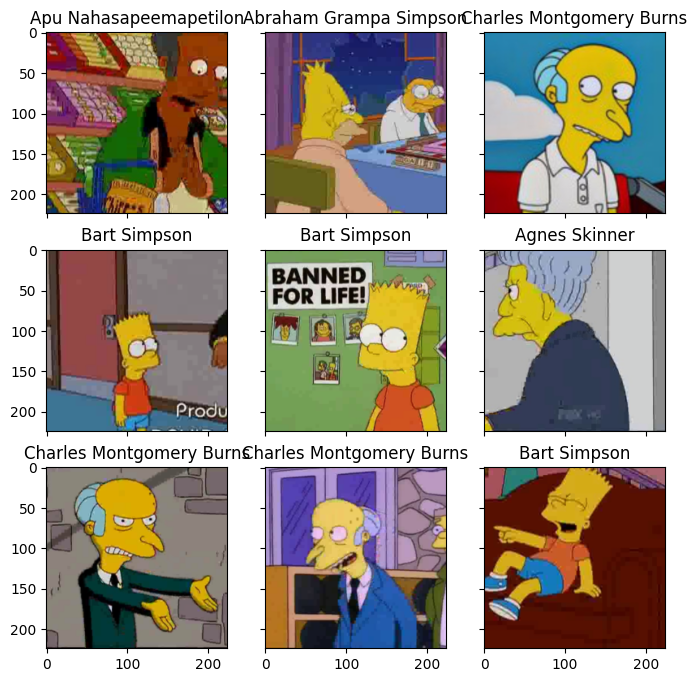

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [11]:
#функция для тренировки модели

use_gpu = torch.cuda.is_available()

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {
    'train': train_loader,
    'val': val_loader
    }
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

class_names = train_dataset.classes


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        # Каждая эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Установить модель в режим обучения
            else:
                model.eval()   # Установить модель в режим оценки

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # Инициализируем градиенты параметров
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                    # Backward pass + оптимизация только если это стадия обучения
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Обновление планировщика скорости обучения
            if phase == 'train':
                scheduler.step()

            # Запоминаем лучшие веса модели, если достигнуто лучшее качество на валидации
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

print("ok")

ok


In [12]:
# Функция для отрисовки тестовых изображений и предсказаний для них:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return
            
print("ok")

ok


In [13]:
# Функция для измерения точности модели на валидационном датасете
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

print("ok")

ok


In [ ]:
# импортируем AlexNet
# model = models.alexnet(pretrained=True)
# Если вам нужна последняя версия весов (если таковая имеется), 
# вы можете использовать AlexNet_Weights.DEFAULT. 
# Это обеспечит загрузку самой актуальной версии предобученных весов для данной модели.
from torchvision.models import alexnet, AlexNet_Weights
model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)


In [ ]:
# посмотрим, что внутри
model

**Fine Tuning способ**





Сконфигурируем - изменим FC-слой и зададим cost function и оптимизирующий алгоритм:

(по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор)

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'AlexNet_fine_tune_2.pth')
print("success")

In [ ]:
model.load_state_dict(torch.load('AlexNet_fine_tune_2.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

In [ ]:
!ls -la .

**Feature Extractor** способ:

In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

model_extractor = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

In [ ]:
# Помним, что по-умолчанию все слои нейросети обучаются заново:
for param in model_extractor.parameters():
    print(param.requires_grad)

In [ ]:
# Сделаем так, чтобы на них не распространялся backpropagation (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

In [ ]:
!ls -la .

Смешанный способ: Мы будем обучать не только последний fully connected слой, но и несколько предпоследних

In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

model_mixed = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

In [ ]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')

In [ ]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))

In [ ]:
!ls -la .

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'AlexNet_mixed.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")


**Еще один способ**

Можно не замораживать все первые слои, а делать так, чтобы шаг градиента на них был меньше. Интерфейс оптимизатора позволяет это делать.

In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

num_features = 9216

model_diff_lr = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

model_diff_lr.classifier = nn.Linear(num_features, 42)

optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.features.parameters(), "lr": 1e-5,}
    ], 
    lr=1e-4
)

criterion = nn.CrossEntropyLoss()


# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_diff_lr.to("cuda")

In [ ]:
_, losses = train_model(model_diff_lr, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_diff_lr.state_dict(), 'AlexNet_diff.pth')

In [ ]:
model_diff_lr.load_state_dict(torch.load('AlexNet_diff.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_diff_lr)))

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'AlexNet_diff.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

**VGG16**

In [ ]:
# Ваш код здесь
from torchvision import models
from torchvision.models import VGG16_Weights

model_extractor = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_extractor

In [ ]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('VGG16.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'VGG16.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

**Inception_v3**

In [ ]:
!pip install --upgrade torchvision


In [ ]:
# from torchvision.models import inception_v3, InceptionV3_Weights

# model_extractor = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)

model_extractor = models.inception_v3(pretrained=True)

In [ ]:
model_extractor.AuxLogits.fc = nn.Linear(768, 42)
model_extractor.fc = nn.Linear(2048, 42)

print("ok")

In [ ]:
model_extractor

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048 # 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("ok")

In [ ]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')

print("ok")

In [ ]:
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'Inceptionv3.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

**Efficient Net**

In [14]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=fce6f64ca38078b79dca6d6de2d532ea2792298b2fe913d7740f6a04144407a1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [15]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 72.1MB/s]

Loaded pretrained weights for efficientnet-b2


In [16]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [17]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
# num_features = 1408 # 25088

num_features = model._fc.in_features # 1408 - определится автоматом
num_classes = 42
model._fc = nn.Linear(num_features, num_classes)


# Заменяем Fully-Connected слой на наш линейный классификатор
# model.classifier = nn.Linear(num_features, num_classes)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("ok")

ok


In [ ]:
%%time
# model_extractor.aux_logits = False
model, losses = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

train Loss: 0.0198 Acc: 0.9820:  12%|█▏        | 3/25 [23:32<2:13:10, 363.20s/it]

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'efficientNet20240101.pth')

print("ok")

In [ ]:
model.load_state_dict(torch.load('efficientNet20240101.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'efficientNet20231220.pth'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")

In [ ]:
# скор на каггл
DEVICE = 'cuda'
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

In [ ]:
# скор на каггл
mode = 'test'
test_dataset = SimpsonsDataset(test_files, mode)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
probs = predict(model, test_loader)
predicted_classes = np.argmax(probs, axis=1)

# Проверить, содержат ли предсказанные классы значения за пределами [0, 41]
if np.any((predicted_classes < 0) | (predicted_classes >= num_classes_label_encoder)):
    print("Найдены недопустимые классы:", predicted_classes[(predicted_classes < 0) | (predicted_classes >= num_classes_label_encoder)])

# Использовать LabelEncoder только для допустимых классов
preds = label_encoder.inverse_transform(predicted_classes)


In [ ]:
# Предположим, что model_extractor - это ваша модель
# num_classes = 42
# model_extractor.classifier = nn.Linear(model_extractor.classifier.in_features, num_classes)


In [ ]:
num_classes_label_encoder = len(label_encoder.classes_)
print("Количество классов в LabelEncoder:", num_classes_label_encoder)


In [ ]:
model

In [ ]:
!ls -la ../input/sample-sub

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("../input/sample-sub/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
my_submit.to_csv('efficientnet.csv', index=False)

In [ ]:
!ls -la .

In [ ]:
import os
from IPython.display import FileLink

# Путь к файлу на вашем ноутбуке Kaggle
file_path = 'efficientnet.csv'

# Проверяем, существует ли файл
if os.path.isfile(file_path):
    # Создаем ссылку для скачивания
    download_link = FileLink(file_path, result_html_prefix="Click here to download: ")
    display(download_link)
else:
    print("Файл не найден")